# Demo 1

Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (1,1) (1,5), (0.001,0.001)
Initial theta(degree): 0.472500(27.072256),0.344900(19.761314)
Initial omega: 0.000000,0.000000
sequence length: 600001 (3000 sec)
dt: 0.005 (sec)

subsampled sequence length: 30000 (3000 sec)
sampling dt: 0.1 (sec)


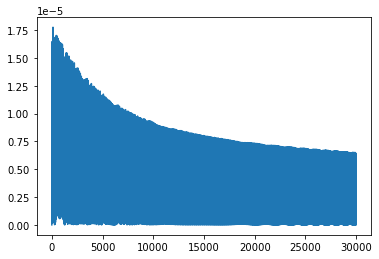

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from utils_dp import DoublePendulum
from utils_dp import calc_double_E, verification


#### Demo1
L1, L2 = 1, 1
M1, M2 = 1, 5
F1, F2 = 0.001, 0.001

init_theta1, init_omega1 = 0.4725, 0.0
init_theta2, init_omega2 = 0.3449, 0.0

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2, F1, F2)
tmax, dt = 3000, 0.005
t, y = dp.generate(tmax=tmax, dt=dt)

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g, 'F1': dp.F1, 'F2': dp.F2}

print('sequence length: {} ({} sec)'.format(len(y), tmax))
print('dt: {} (sec)\n'.format(dt))


subsampling = True

if subsampling:
    # Fine dt for generation and subsample for learning
    sampling_step = 20    # sample a row for every the step.
    sampling_dt = dt*sampling_step
    sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
    sampling_t = t[sampling_ind]
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y[sampling_ind]
    
else:
    sampling_dt = dt
    sampling_t = t
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y

V, T, E = calc_double_E(X, **dp_params)
X_np = np.array(X)
    
print('subsampled sequence length: {} ({} sec)'.format(len(X), tmax))
print('sampling dt: {} (sec)'.format(sampling_dt))

Text(0, 0.5, 'Velocity (rad/s)')

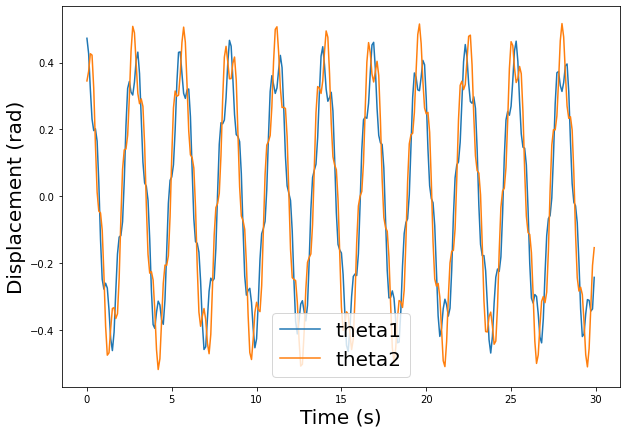

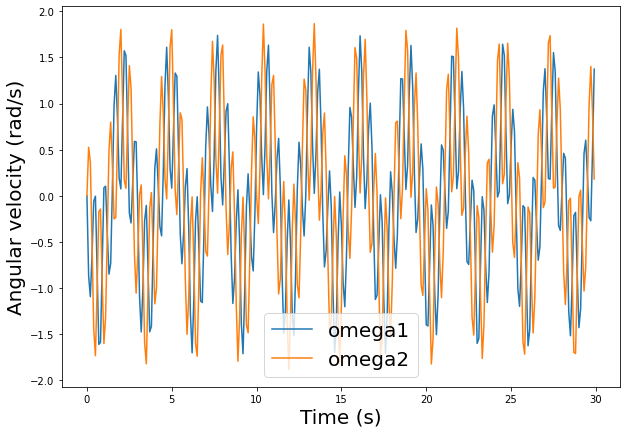

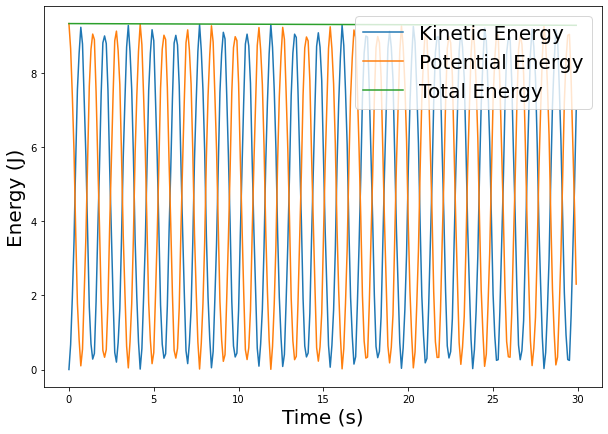

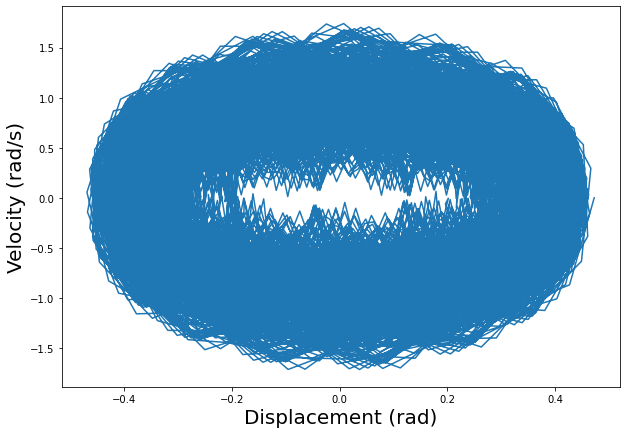

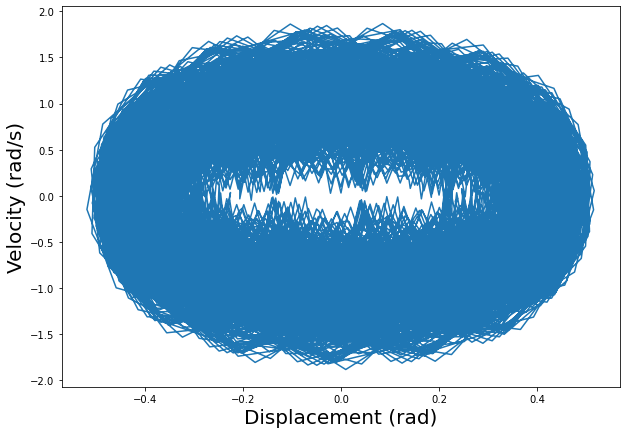

In [3]:
'''Plotting'''
# Unpack z and theta as a function of time
theta1, theta2 = X[:,0], X[:,2]
omega1, omega2 = X[:,1], X[:,3]

min_ind, max_ind = 0, len(X)//100
plt.figure(0, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], theta1[min_ind:max_ind], label='theta1')
plt.plot(sampling_t[min_ind:max_ind], theta2[min_ind:max_ind], label='theta2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], omega1[min_ind:max_ind], label='omega1')
plt.plot(sampling_t[min_ind:max_ind], omega2[min_ind:max_ind], label='omega2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Angular velocity (rad/s)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(2, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], T[min_ind:max_ind], label='Kinetic Energy')
plt.plot(sampling_t[min_ind:max_ind], V[min_ind:max_ind], label='Potential Energy')
plt.plot(sampling_t[min_ind:max_ind], E[min_ind:max_ind], label='Total Energy')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Energy (J)', fontsize=20)

plt.figure(3, figsize=(10,7))
plt.plot(theta1, omega1)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

plt.figure(4, figsize=(10,7))
plt.plot(theta2, omega2)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

In [1]:
'''
Data preprocessing for NN
'''
import random
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset



X = torch.tensor(X_np, dtype=torch.float32, device=device)

num_samples = X.shape[0]
# static_input_dim = static_X.shape[1]    # (L1,L2,M1,M2,F1,F2)
input_dim = X.shape[1]//2    # (theta1, omega1, theta2, omega2)

# 60:10:30 split
train_X, train_y = X[:int(num_samples*0.6), :input_dim], X[:int(num_samples*0.6), input_dim:]
valid_X, valid_y = X[int(num_samples*0.6):int(num_samples*0.7), :input_dim], X[int(num_samples*0.6):int(num_samples*0.7), input_dim:]
test_X, test_y = X[int(num_samples*0.7):, :input_dim], X[int(num_samples*0.7):, input_dim:]

total_train_sample = len(train_X)
total_valid_sample = len(valid_X)
total_test_sample = len(test_X)

batch_size = 64
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=valid_X.shape[0])
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=test_X.shape[0])

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

NameError: name 'X_np' is not defined

In [146]:
from torch.distributions.beta import Beta
from model import RuleEncoder, DataEncoder, Net, NaiveModel, SharedNet, DataonlyNet



model_type = 'dataonly-nobatch-demo1-with-rule'

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



print('model_type:{}\tseed {} started.'.format(model_type, seed))

lr = 0.001
SKIP = True    # Delta value (x(t+1)-x(t)) prediction if True else absolute value (x(t+1)) prediction
input_dim = 4
input_dim_encoder = 16
output_dim_encoder = 64
hidden_dim_encoder = 64
hidden_dim_db = 64
output_dim = 4
n_layers = 2
merge = 'cat'
        
rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)
        
total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
# loss_task = nn.MSELoss()
l1_func = nn.L1Loss()
best_val_loss = float('inf')
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 1000
early_stopping_thld = 10
counter_early_stopping = 1
log_interval = 500
valid_freq = 5
if SKIP:
    saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.skip.demo.pt' \
                        .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
else:
    saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.no-skip.pt' \
                        .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
saved_filename =  os.path.join('saved_models', saved_filename)
print('saved_filename: {}\n'.format(saved_filename))

# Training
loss_train, loss_train_rule, loss_train_ratio = [], [], []
loss_val, loss_val_rule, loss_val_ratio = [], [], []
for epoch in range(1, epochs+1):
    model.train()
    loss_train_batch = []
    loss_train_rule_batch = []
    loss_train_ratio_batch = []
    loss_ratio = 0
    for batch_idx, batch_data in enumerate(train_loader):
        batch_train_x = batch_data[0]# + 0.01*torch.randn(batch_data[0].shape).to(device)    # Adding noise
        batch_train_y = batch_data[1]

        optimizer.zero_grad()

        alpha = 0.0
        
        output = model(batch_train_x, alpha=alpha)    # only rule if alpha=1.    \hat{X}_{t+1}

        _, _, curr_E = calc_double_E(batch_train_x, **dp_params)    # E(X_t)    Energy of X_t (Current energy)
        _, _, next_E = calc_double_E(batch_train_y, **dp_params)    # E(X_{t+1})    Energy of X_{t+1} (Next energy from ground truth)
        _, _, pred_E = calc_double_E(output, **dp_params)    # E(\hat{X}_t+1)    Energy of \hat{X}_{t+1} (Next energy from prediction)

        loss_task = loss_task_func(output, batch_train_y)    # state prediction
        loss_rule = loss_rule_func(pred_E, curr_E)    # energy damping by friction: E_{t+1}<=E_t
        loss_mae = l1_func(output, batch_train_y).item()
        loss_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * pred_E.shape[0] / total_train_sample)

#         loss = loss_task
        loss = loss_task + loss_rule
        loss.backward()
        optimizer.step()
        
        loss_train_batch.append(loss_task.item())
        loss_train_rule_batch.append(loss_rule.item())
#         loss_train_ratio_batch.append(loss_ratio)
        
    loss_train.append(np.mean(loss_train_batch))
    loss_train_rule.append(np.mean(loss_train_rule_batch))
    loss_train_ratio.append(loss_ratio)

    # Evaluate on validation set
    if epoch % valid_freq == 0:
        model.eval()
        with torch.no_grad():
            val_loss_task = 0
            val_loss_rule = 0
            val_ratio = 0
            for val_x, val_y in valid_loader:
#                 val_x += 0.01*torch.randn(val_x.shape).to(device)
                output = model(val_x, alpha=0.0)
                _, _, curr_E = calc_double_E(val_x, **dp_params)
                _, _, pred_E = calc_double_E(output, **dp_params)

                val_loss_task += (loss_task_func(output, val_y).item() * val_x.shape[0] / total_valid_sample)
                val_loss_rule += (loss_rule_func(pred_E, curr_E) * val_x.shape[0] / total_valid_sample)
                val_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * val_x.shape[0] / total_valid_sample)
                
            loss_val.append(val_loss_task)
            loss_val_rule.append(val_loss_rule)
            loss_val_ratio.append(val_ratio)

        if val_loss_task < best_val_loss:
            counter_early_stopping = 1
            best_val_loss = val_loss_task
            print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f}  Ratio(Rule): {:.3f} (alpha: 0.0)\t best model is updated %%%%'
                  .format(epoch, best_val_loss, val_loss_rule, val_ratio))
            torch.save({
                'epoch': epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss
            }, saved_filename)
        else:
            print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f} Ratio(Rule): {:.3f} (alpha: 0.0) ({}/{})'
                  .format(epoch, val_loss_task, val_loss_rule, val_ratio, counter_early_stopping, early_stopping_thld))
            if counter_early_stopping >= early_stopping_thld:
                break
            else:
                counter_early_stopping += 1


# Test
rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model_eval = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

model_eval.eval()
with torch.no_grad():
    test_loss_task = 0
    for test_x, test_y in test_loader:
        output = model_eval(test_x, alpha=0.0)
        test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss_task))

#### Check which parameters are updated.
print('seed: {}'.format(seed))

model_type:dataonly-nobatch-demo1-with-rule	seed 42 started.
total parameters: 13060
saved_filename: saved_models/dp-dataonly-nobatch-demo1-with-rule_0.4725_0.0_0.3449_0.0-seed42.skip.demo.pt

[Valid] Epoch: 5 Loss(Task): 0.003307 Loss(Rule): 0.000000  Ratio(Rule): 1.000 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 10 Loss(Task): 0.001913 Loss(Rule): 0.000650  Ratio(Rule): 0.887 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 15 Loss(Task): 0.001115 Loss(Rule): 0.000000  Ratio(Rule): 1.000 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 20 Loss(Task): 0.004120 Loss(Rule): 0.000000 Ratio(Rule): 1.000 (alpha: 0.0) (1/10)
[Valid] Epoch: 25 Loss(Task): 0.001306 Loss(Rule): 0.000270 Ratio(Rule): 0.892 (alpha: 0.0) (2/10)
[Valid] Epoch: 30 Loss(Task): 0.001055 Loss(Rule): 0.000000  Ratio(Rule): 1.000 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 35 Loss(Task): 0.001321 Loss(Rule): 0.000000 Ratio(Rule): 1.000 (alpha: 0.0) (1/10)
[Valid] Epoch: 40 Loss(Task

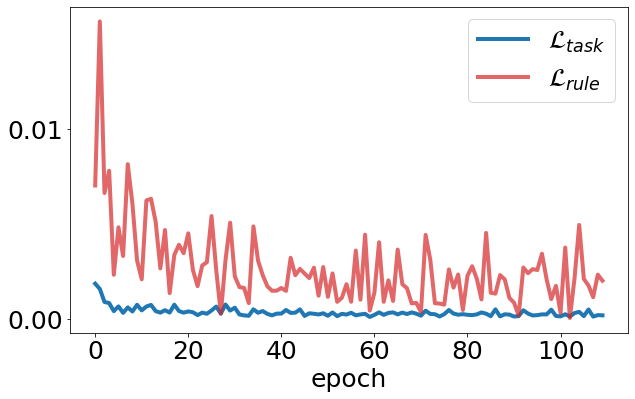

In [133]:
fig, ax = plt.subplots(figsize=(10,6))
# ax.plot(loss_train, '-', color='k', lw=4, alpha=0.9, label=r'$\mathcal{L}_{task}$')
# ax.plot(loss_train_rule, '-', color='b', lw=4, alpha=0.7, label=r'$\mathcal{L}_{rule}$')

ax.plot(loss_val, '-', color='tab:blue', lw=4, alpha=1.0, label=r'$\mathcal{L}_{task}$')
ax.plot(loss_val_rule, '-', color='tab:red', lw=4, alpha=0.7, label=r'$\mathcal{L}_{rule}$')
# ax.plot(loss_val_ratio, '-', color='g', lw=4, alpha=0.7, label=r'$\mathcal{L}_{rule}$')

ax.yaxis.set_ticks(np.arange(0, 0.02, 0.01))
plt.xlabel('epoch', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)

plt.savefig('img/dp-motivation-loss.pdf', bbox_inches='tight')

# plt.plot(loss_train, '.-')
# plt.plot(loss_val, '.-')

# plt.plot(loss_train_rule, '.-')
# plt.plot(loss_val_rule, '.-')

# plt.plot(loss_train_ratio, '.-')
# plt.plot(loss_val_ratio, '.-')



Test set: Average loss: 0.00022117 (alpha:0.0)
ratio of verified predictions: 0.928444 (alpha:0.0)


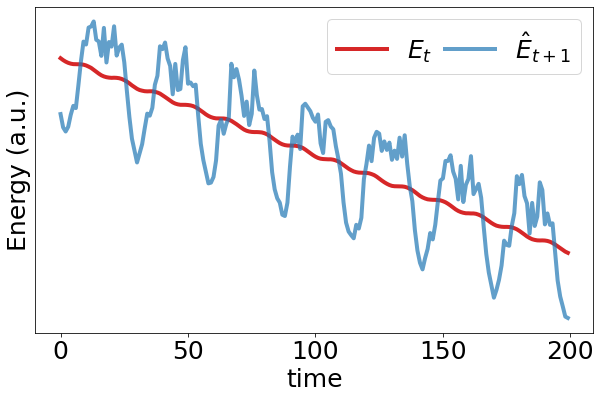

In [247]:
import matplotlib as mpl

model_eval.eval()
alpha = 0.0
with torch.no_grad():
    for test_x, test_y in test_loader:
        break
        
    output = model_eval(test_x, alpha=alpha)
    
    test_loss_task = loss_task_func(output, test_y).item()  # sum up batch loss

    _, _, curr_E = calc_double_E(test_x, **dp_params)
    _, _, next_E = calc_double_E(test_y, **dp_params)
    _, _, pred_E = calc_double_E(output, **dp_params)

    test_ratio = verification(curr_E, pred_E, threshold=0.0).item()
    print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
    print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

    

    
'''
Visualization of predicted/ground truth observation
    - To show the prediction is very accurate from dataonly.
'''
# fig, ax = plt.subplots(figsize=(10,8))

# ind = 50

# ylabel = {0: r'$\theta_1$', 1: r'$\omega_1$', 2: r'$\theta_2$', 3: r'$\omega_2$'}
# ylabel_pred = {0: r'$\hat{\theta}_1$', 1: r'$\hat{\omega}_1$', 2: r'$\hat{\theta}_2$', 3: r'$\hat{\omega}_2$'}
# input_x = test_x.cpu().numpy()
# pred = output.cpu().numpy()
# target = test_y.cpu().numpy()
# input_ind = 0    # 0: theta1, 1: omega1, 2: theta2, 3: omega2
# ax.plot(target[:ind, input_ind], '-*', color='black', lw=4, ms=15, alpha=0.9, label=ylabel[input_ind])
# ax.plot(pred[:ind, input_ind], 'o', color='red', lw=4, ms=15, alpha=0.4, label=ylabel_pred[input_ind])
# input_ind = 1    # 0: theta1, 1: omega1, 2: theta2, 3: omega2
# ax.plot(target[:ind, input_ind], '--*', color='black', lw=4, ms=15, alpha=0.9, label=ylabel[input_ind])
# ax.plot(pred[:ind, input_ind], 'o', color='blue', lw=4, ms=15, alpha=0.4, label=ylabel_pred[input_ind])

# ax.yaxis.set_ticks(np.arange(-0.75, 0.76, 0.5))
# plt.xlabel('time', fontsize=25)
# # plt.ylabel(ylabel[input_ind] + ' (a.u.)', fontsize=20)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# # plt.yticks([])
# plt.legend(fontsize=20)

# plt.savefig('img/dp-motivation1-resize.pdf', bbox_inches='tight')

'''
Visualization of predicted/ground truth Energy
    - Energy prediction violates the common rule.
'''

ind = 200
fig, ax = plt.subplots(figsize=(10,6))

# ind = 100
ax.plot(curr_E.cpu().numpy()[:ind], '-', color='tab:red', lw=4, ms=10, alpha=1.0, label=r'$E_t$')
ax.plot(pred_E_norule[:ind], '-', color='tab:blue', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$')
# ax.plot(pred_E.cpu().numpy()[:ind], '-', color='tab:blue', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$' + ' w/o a rule')
# ax.plot(curr_E.cpu().numpy()[:ind] + 0.1*(pred_E_norule[:ind]-np.mean(pred_E_norule[:ind])) + 1*np.arange(-0.001, 0.001, 0.00001) - 0.00023,
#         '-', color='tab:blue', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$')

# ax.plot(pred_E.cpu().numpy()[:ind] - 0.003, '-', color='tab:blue', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$')

# ax.plot(pred_E.cpu().numpy()[:ind]-0.004, '-', color='tab:blue', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$')
# ax.plot(next_E.cpu().numpy()[:ind], '-', color='tab:blue', lw=4, ms=10, alpha=1.0, label=r'$E_{t+1}$')


plt.xlabel('time', fontsize=25)
plt.ylabel('Energy (a.u.)', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.xaxis.set_ticks(np.arange(0, 201, 50))
# ax.yaxis.set_ticks(np.arange(7.325, 7.346, 0.01))
plt.yticks([])
# plt.legend(fontsize=25, ncol=1, columnspacing=0.5)
plt.legend(fontsize=25, ncol=2, columnspacing=0.5)


# plt.savefig('img/dp-motivation-energy-with-rule.pdf', bbox_inches='tight')
# plt.savefig('img/dp-motivation-energy-without-rule.pdf', bbox_inches='tight')
# plt.savefig('img/dp-motivation-energy-with-rule.pdf', bbox_inches='tight')

In [215]:
np.arange(-0.001, 0.001, 0.00001)

(200,)

In [207]:
curr_E.cpu().numpy()[:ind]

array([7.345194 , 7.3450556, 7.3449416, 7.3448544, 7.3447948, 7.3447604,
       7.344757 , 7.34475  , 7.344745 , 7.344719 , 7.3446636, 7.3445797,
       7.3444834, 7.344345 , 7.344201 , 7.3440638, 7.3439417, 7.3438587,
       7.3438034, 7.343772 , 7.3437552, 7.3437643, 7.343755 , 7.343728 ,
       7.3436728, 7.343589 , 7.3434834, 7.3433523, 7.343204 , 7.3430743,
       7.342952 , 7.342864 , 7.3428154, 7.3427773, 7.342765 , 7.3427715,
       7.342768 , 7.3427315, 7.34268  , 7.342602 , 7.3424788, 7.342353 ,
       7.3422203, 7.34208  , 7.34196  , 7.3418694, 7.341814 , 7.3417816,
       7.3417816, 7.341779 , 7.341765 , 7.3417377, 7.3416867, 7.3416023,
       7.341489 , 7.341357 , 7.341223 , 7.341082 , 7.3409667, 7.3408804,
       7.3408217, 7.3407874, 7.3407845, 7.3407803, 7.3407774, 7.34075  ,
       7.3406873, 7.340606 , 7.340487 , 7.3403635, 7.340223 , 7.34009  ,
       7.339965 , 7.3398776, 7.3398247, 7.3397946, 7.339783 , 7.339784 ,
       7.3397737, 7.339754 , 7.339699 , 7.3396173, 

# Demo 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.426189469827033 0.0 -0.7528010775698667 0.0
Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (3,1.5) (1,3), (0.001,0.0005)
Initial theta(degree): 0.426189(24.418858),-0.752801(-43.132325)
Initial omega: 0.000000,0.000000
sequence length: 600001 (3000 sec)
dt: 0.005 (sec)

subsampled sequence length: 30000 (3000 sec)
sampling dt: 0.1 (sec)


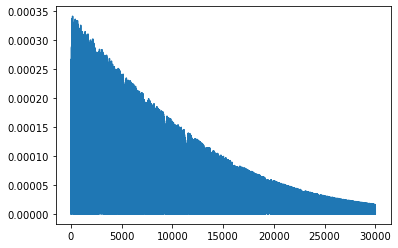

In [25]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from utils_dp import DoublePendulum
from utils_dp import calc_double_E, verification


#### Demo2
L1, L2 = 3, 1.5
M1, M2 = 1, 3
F1, F2 = 0.001, 0.0005

init_theta1, init_omega1 = np.random.uniform(-np.pi/4, np.pi/4), 0.0
init_theta2, init_omega2 = np.random.uniform(-np.pi/4, np.pi/4), 0.0
# init_theta1, init_omega1 = 0.4725, 0.0
# init_theta2, init_omega2 = 0.3449, 0.0
print(init_theta1, init_omega1, init_theta2, init_omega2)

#### Fast damping
# init_theta1, init_omega1 = -1.317105, 0.0
# init_theta2, init_omega2 = 1.349789, 0.0
#### Slow damping
# init_theta1, init_omega1 = 1.1365, 0.0
# init_theta2, init_omega2 = 0.2636, 0.0

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2, F1, F2)
tmax, dt = 3000, 0.005
t, y = dp.generate(tmax=tmax, dt=dt)

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g, 'F1': dp.F1, 'F2': dp.F2}
# V, T, E = calc_double_E(y, **dp_params)

print('sequence length: {} ({} sec)'.format(len(y), tmax))
print('dt: {} (sec)\n'.format(dt))


subsampling = True

if subsampling:
    #### Fine dt for generation and subsample for learning
    sampling_step = 20    # sample a row for every the step.
    sampling_dt = dt*sampling_step
    sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
    sampling_t = t[sampling_ind]
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y[sampling_ind]
    
#     scaled_y = scaled_y[sampling_ind]
#     input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
#     X = input_output_y
    ####
else:
    sampling_dt = dt
    sampling_t = t
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y
    

    
V, T, E = calc_double_E(X, **dp_params)
X_np = np.array(X)
    
print('subsampled sequence length: {} ({} sec)'.format(len(X), tmax))
print('sampling dt: {} (sec)'.format(sampling_dt))

_, _, cE = calc_double_E(X[:,:4], **dp_params)
_, _, nE = calc_double_E(X[:,4:], **dp_params)

plt.plot(cE-nE)

Text(0, 0.5, 'Velocity (rad/s)')

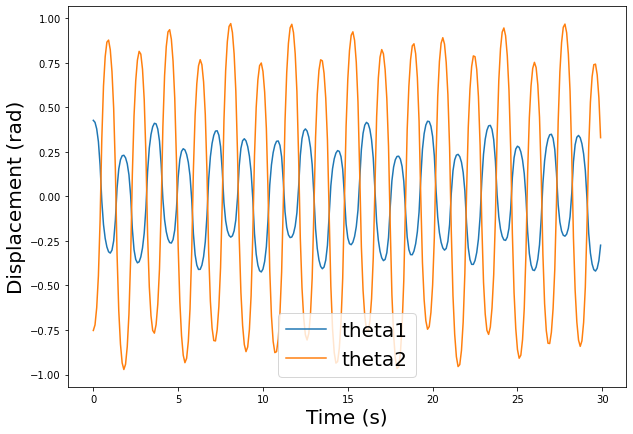

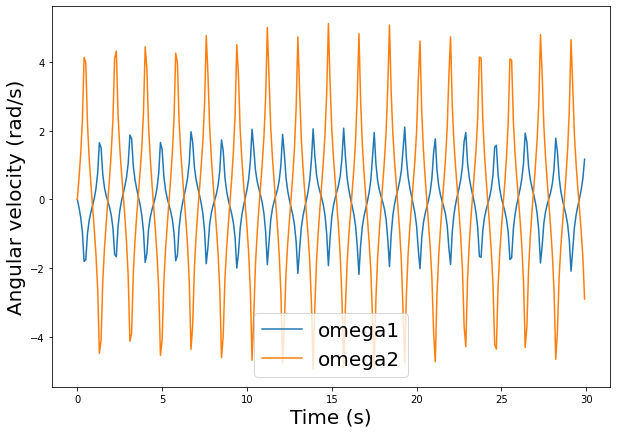

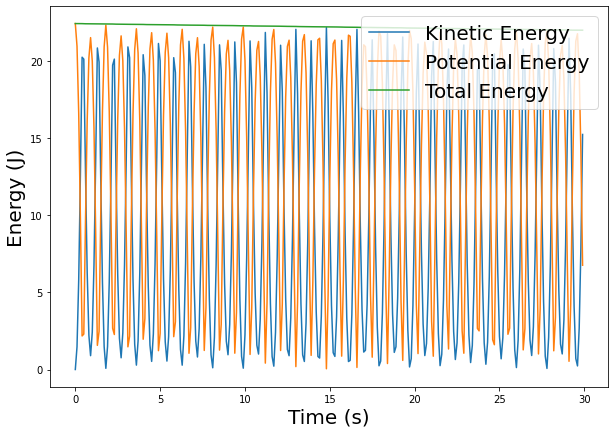

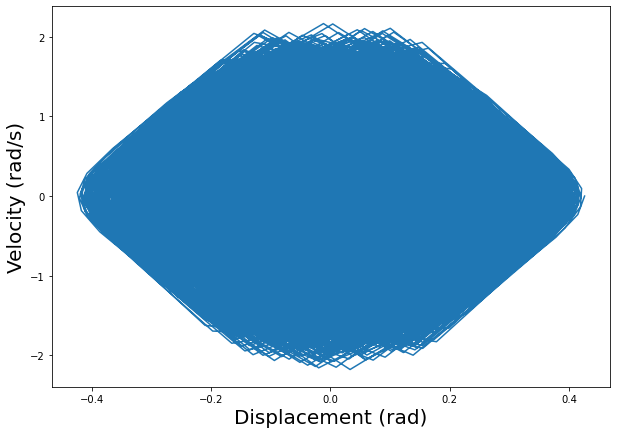

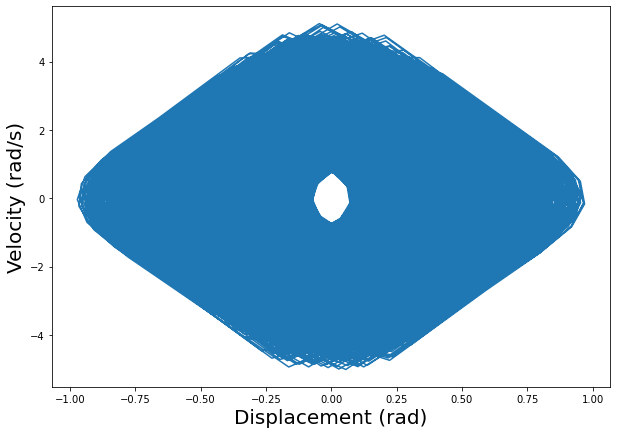

In [26]:
'''Plotting'''
# Unpack z and theta as a function of time
theta1, theta2 = X[:,0], X[:,2]
omega1, omega2 = X[:,1], X[:,3]

min_ind, max_ind = 0, len(X)//100
plt.figure(0, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], theta1[min_ind:max_ind], label='theta1')
plt.plot(sampling_t[min_ind:max_ind], theta2[min_ind:max_ind], label='theta2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Displacement (rad)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(1, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], omega1[min_ind:max_ind], label='omega1')
plt.plot(sampling_t[min_ind:max_ind], omega2[min_ind:max_ind], label='omega2')
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Angular velocity (rad/s)', fontsize=20)
plt.legend(loc='lower center', fontsize=20)

plt.figure(2, figsize=(10,7))
plt.plot(sampling_t[min_ind:max_ind], T[min_ind:max_ind], label='Kinetic Energy')
plt.plot(sampling_t[min_ind:max_ind], V[min_ind:max_ind], label='Potential Energy')
plt.plot(sampling_t[min_ind:max_ind], E[min_ind:max_ind], label='Total Energy')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('Energy (J)', fontsize=20)

plt.figure(3, figsize=(10,7))
plt.plot(theta1, omega1)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

plt.figure(4, figsize=(10,7))
plt.plot(theta2, omega2)
plt.xlabel('Displacement (rad)', fontsize=20)
plt.ylabel('Velocity (rad/s)', fontsize=20)

In [27]:
'''
Data preprocessing for NN
'''
import random
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset



X = torch.tensor(X_np, dtype=torch.float32, device=device)

num_samples = X.shape[0]
# static_input_dim = static_X.shape[1]    # (L1,L2,M1,M2,F1,F2)
input_dim = X.shape[1]//2    # (theta1, omega1, theta2, omega2)

# 60:10:30 split
train_X, train_y = X[:int(num_samples*0.6), :input_dim], X[:int(num_samples*0.6), input_dim:]
valid_X, valid_y = X[int(num_samples*0.6):int(num_samples*0.7), :input_dim], X[int(num_samples*0.6):int(num_samples*0.7), input_dim:]
test_X, test_y = X[int(num_samples*0.7):, :input_dim], X[int(num_samples*0.7):, input_dim:]

total_train_sample = len(train_X)
total_valid_sample = len(valid_X)
total_test_sample = len(test_X)

batch_size = 64
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=valid_X.shape[0])
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=test_X.shape[0])

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

data size: 18000/3000/9000


In [15]:
from torch.distributions.beta import Beta
from model import RuleEncoder, DataEncoder, Net, NaiveModel, SharedNet, DataonlyNet



model_type = 'dataonly-nobatch-demo2'

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



print('model_type:{}\tseed {} started.'.format(model_type, seed))

lr = 0.001
SKIP = True    # Delta value (x(t+1)-x(t)) prediction if True else absolute value (x(t+1)) prediction
input_dim = 4
input_dim_encoder = 16
output_dim_encoder = 64
hidden_dim_encoder = 64
hidden_dim_db = 64
output_dim = 4
n_layers = 2
merge = 'cat'
        
rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)
        
total_params = sum(p.numel() for p in model.parameters())
print("total parameters: {}".format(total_params))

loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
# loss_task = nn.MSELoss()
l1_func = nn.L1Loss()
best_val_loss = float('inf')
optimizer = optim.Adam(model.parameters(), lr=lr)

epochs = 1000
early_stopping_thld = 10
counter_early_stopping = 1
log_interval = 500
valid_freq = 5
if SKIP:
    saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.skip.demo.pt' \
                        .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
else:
    saved_filename = 'dp-{}_{:.4f}_{:.1f}_{:.4f}_{:.1f}-seed{}.no-skip.pt' \
                        .format(model_type, init_theta1, init_omega1, init_theta2, init_omega2, seed)
saved_filename =  os.path.join('saved_models', saved_filename)
print('saved_filename: {}\n'.format(saved_filename))

# Training
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch_data in enumerate(train_loader):
        batch_train_x = batch_data[0]# + 0.01*torch.randn(batch_data[0].shape).to(device)    # Adding noise
        batch_train_y = batch_data[1]

        optimizer.zero_grad()

        alpha = 0.0
        
        output = model(batch_train_x, alpha=alpha)    # only rule if alpha=1.    \hat{X}_{t+1}

        _, _, curr_E = calc_double_E(batch_train_x, **dp_params)    # E(X_t)    Energy of X_t (Current energy)
        _, _, next_E = calc_double_E(batch_train_y, **dp_params)    # E(X_{t+1})    Energy of X_{t+1} (Next energy from ground truth)
        _, _, pred_E = calc_double_E(output, **dp_params)    # E(\hat{X}_t+1)    Energy of \hat{X}_{t+1} (Next energy from prediction)

        loss_task = loss_task_func(output, batch_train_y)    # state prediction
        loss_rule = loss_rule_func(pred_E, curr_E)    # energy damping by friction: E_{t+1}<=E_t
        loss_mae = l1_func(output, batch_train_y).item()

        loss = loss_task
        loss.backward()
        optimizer.step()


    # Evaluate on validation set
    if epoch % valid_freq == 0:
        model.eval()
        with torch.no_grad():
            val_loss_task = 0
            val_loss_rule = 0
            val_ratio = 0
            for val_x, val_y in valid_loader:
#                 val_x += 0.01*torch.randn(val_x.shape).to(device)
                output = model(val_x, alpha=0.0)
                _, _, curr_E = calc_double_E(val_x, **dp_params)
                _, _, pred_E = calc_double_E(output, **dp_params)

                val_loss_task += (loss_task_func(output, val_y).item() * val_x.shape[0] / total_valid_sample)
                val_loss_rule += (loss_rule_func(pred_E, curr_E) * val_x.shape[0] / total_valid_sample)
                val_ratio += (verification(curr_E, pred_E, threshold=0.0).item() * val_x.shape[0] / total_valid_sample)

        if val_loss_task < best_val_loss:
            counter_early_stopping = 1
            best_val_loss = val_loss_task
            print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f}  Ratio(Rule): {:.3f} (alpha: 0.0)\t best model is updated %%%%'
                  .format(epoch, best_val_loss, val_loss_rule, val_ratio))
            torch.save({
                'epoch': epoch,
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_val_loss
            }, saved_filename)
        else:
            print('[Valid] Epoch: {} Loss(Task): {:.6f} Loss(Rule): {:.6f} Ratio(Rule): {:.3f} (alpha: 0.0) ({}/{})'
                  .format(epoch, val_loss_task, val_loss_rule, val_ratio, counter_early_stopping, early_stopping_thld))
            if counter_early_stopping >= early_stopping_thld:
                break
            else:
                counter_early_stopping += 1


# Test
rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
model_eval = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)

checkpoint = torch.load(saved_filename)
model_eval.load_state_dict(checkpoint['model_state_dict'])
print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

model_eval.eval()
with torch.no_grad():
    test_loss_task = 0
    for test_x, test_y in test_loader:
        output = model_eval(test_x, alpha=0.0)
        test_loss_task += (loss_task_func(output, test_y).item() * test_x.shape[0] / total_test_sample)  # sum up batch loss

print('\nTest set: Average loss: {:.8f}\n'.format(test_loss_task))

#### Check which parameters are updated.
print('seed: {}'.format(seed))

model_type:dataonly-nobatch-demo2	seed 42 started.
total parameters: 13060
saved_filename: saved_models/dp-dataonly-nobatch-demo2_0.4725_0.0_0.3449_0.0-seed42.skip.demo.pt

[Valid] Epoch: 5 Loss(Task): 0.000537 Loss(Rule): 0.005069  Ratio(Rule): 0.485 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 10 Loss(Task): 0.000268 Loss(Rule): 0.001886  Ratio(Rule): 0.536 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 15 Loss(Task): 0.000445 Loss(Rule): 0.001753 Ratio(Rule): 0.503 (alpha: 0.0) (1/10)
[Valid] Epoch: 20 Loss(Task): 0.000402 Loss(Rule): 0.001871 Ratio(Rule): 0.504 (alpha: 0.0) (2/10)
[Valid] Epoch: 25 Loss(Task): 0.000178 Loss(Rule): 0.000938  Ratio(Rule): 0.532 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 30 Loss(Task): 0.000221 Loss(Rule): 0.001265 Ratio(Rule): 0.539 (alpha: 0.0) (1/10)
[Valid] Epoch: 35 Loss(Task): 0.000124 Loss(Rule): 0.000691  Ratio(Rule): 0.448 (alpha: 0.0)	 best model is updated %%%%
[Valid] Epoch: 40 Loss(Task): 0.000288 Loss(Rul

Test set: Average loss: 0.00158278 (alpha:0.0)
ratio of verified predictions: 0.484333 (alpha:0.0)


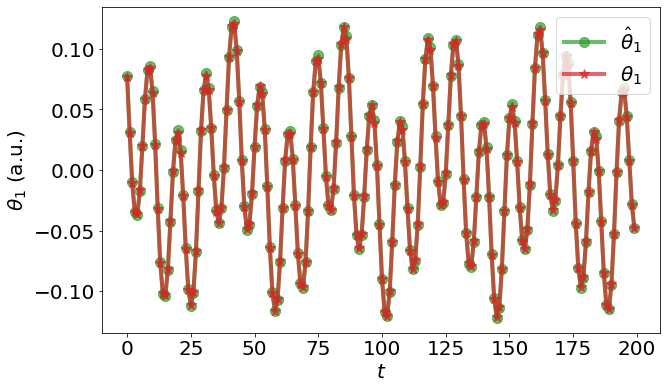

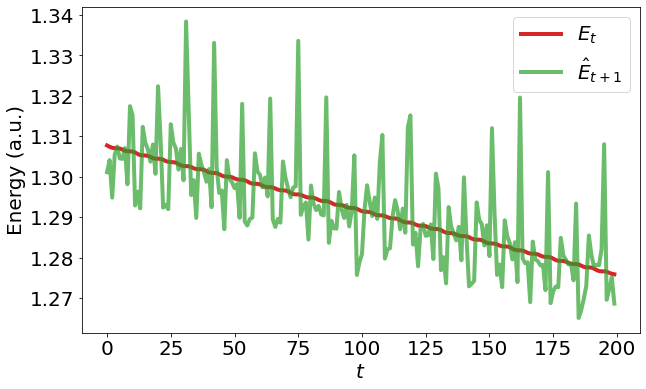

In [21]:
import matplotlib as mpl

model_eval.eval()
alpha = 0.0
with torch.no_grad():
    for test_x, test_y in test_loader:
        break
        
    output = model_eval(test_x, alpha=alpha)
    
    test_loss_task = loss_task_func(output, test_y).item()  # sum up batch loss

    _, _, curr_E = calc_double_E(test_x, **dp_params)
    _, _, next_E = calc_double_E(test_y, **dp_params)
    _, _, pred_E = calc_double_E(output, **dp_params)

    test_ratio = verification(curr_E, pred_E, threshold=0.0).item()
    print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
    print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

    

    
'''
Visualization of predicted/ground truth observation
    - To show the prediction is very accurate from dataonly.
'''
fig, ax = plt.subplots(figsize=(10,6))

ind = 200
input_ind = 0    # 0: theta1, 1: omega1, 2: theta2, 3: omega2
ylabel = {0: r'$\theta_1$', 1: r'$\omega_1$', 2: r'$\theta_2$', 3: r'$\omega_2$'}
ylabel_pred = {0: r'$\hat{\theta}_1$', 1: r'$\hat{\omega}_1$', 2: r'$\hat{\theta}_2$', 3: r'$\hat{\omega}_2$'}
input_x = test_x.cpu().numpy()
pred = output.cpu().numpy()
target = test_y.cpu().numpy()
ax.plot(pred[:ind, input_ind], 'o-', color='tab:green', lw=4, ms=10, alpha=0.7, label=ylabel_pred[input_ind])
ax.plot(target[:ind, input_ind], '-*', color='tab:red', lw=4, ms=10, alpha=0.7, label=ylabel[input_ind])

plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(ylabel[input_ind] + ' (a.u.)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([])
plt.legend(fontsize=20)


'''
Visualization of predicted/ground truth Energy
    - Energy prediction violates the common rule.
'''

fig, ax = plt.subplots(figsize=(10,6))

# ind = 100
ax.plot(curr_E.cpu().numpy()[:ind], '-', color='tab:red', lw=4, ms=10, alpha=1.0, label=r'$E_t$')
ax.plot(pred_E.cpu().numpy()[:ind], '-', color='tab:green', lw=4, ms=10, alpha=0.7, label=r'$\hat{E}_{t+1}$')
# ax.plot(next_E.cpu().numpy()[:ind], '-', color='tab:blue', lw=4, ms=10, alpha=1.0, label=r'$E_{t+1}$')

plt.xlabel(r'$t$', fontsize=20)
plt.ylabel('Energy (a.u.)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.yticks([])
plt.legend(fontsize=20)

# plt.savefig('img/dp-data-only.pdf', bbox_inches='tight')
# plt.savefig('img/dp-hybrid.pdf', bbox_inches='tight')

# Transferability

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.3225 0.0 0.2749 0.0
Length (L1,L2), Mass (M1,M2), and Friction (F1,F2) of a string: (1,1) (1,5), (0.001,0.001)
Initial theta(degree): 0.322500(18.477889),0.274900(15.750610)
Initial omega: 0.000000,0.000000
sequence length: 600001 (3000 sec)
dt: 0.005 (sec)

subsampled sequence length: 30000 (3000 sec)
sampling dt: 0.1 (sec)
data size: 18000/3000/6000


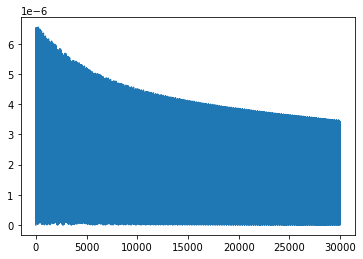

In [67]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import os

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from utils_dp import DoublePendulum
from utils_dp import calc_double_E, verification


#### Demo1
L1, L2 = 1, 1
M1, M2 = 1, 5
F1, F2 = 0.001, 0.001
# F1, F2 = 0.01, 0.01

# init_theta1, init_omega1 = np.random.uniform(-np.pi/4, np.pi/4), 0.0
# init_theta2, init_omega2 = np.random.uniform(-np.pi/4, np.pi/4), 0.0
# init_theta1, init_omega1 = 0.4725, 0.0
# init_theta2, init_omega2 = 0.3449, 0.0
init_theta1, init_omega1 = 0.3225, 0.0     # 
init_theta2, init_omega2 = 0.2749, 0.0

print(init_theta1, init_omega1, init_theta2, init_omega2)

dp = DoublePendulum(L1, L2, M1, M2, init_theta1, init_omega1, init_theta2, init_omega2, F1, F2)
tmax, dt = 3000, 0.005
t, y = dp.generate(tmax=tmax, dt=dt)

dp_params = {'M1': dp.M1, 'M2': dp.M2, 'L1': dp.L1, 'L2': dp.L2, 'g': dp.g, 'F1': dp.F1, 'F2': dp.F2}
# V, T, E = calc_double_E(y, **dp_params)

print('sequence length: {} ({} sec)'.format(len(y), tmax))
print('dt: {} (sec)\n'.format(dt))


subsampling = True

if subsampling:
    #### Fine dt for generation and subsample for learning
    sampling_step = 20    # sample a row for every the step.
    sampling_dt = dt*sampling_step
    sampling_ind = np.arange(0, t.shape[0]-1, sampling_step)
    sampling_t = t[sampling_ind]
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y[sampling_ind]
    
#     scaled_y = scaled_y[sampling_ind]
#     input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
#     X = input_output_y
    ####
else:
    sampling_dt = dt
    sampling_t = t
    
    scaler = 1.0
    scaled_y = np.array(y)*scaler
    input_output_y = np.concatenate((scaled_y[:-1], scaled_y[1:]), axis=1)    # [[input, output]]
    X = input_output_y
    

    
V, T, E = calc_double_E(X, **dp_params)
X_np = np.array(X)
    
print('subsampled sequence length: {} ({} sec)'.format(len(X), tmax))
print('sampling dt: {} (sec)'.format(sampling_dt))

_, _, cE = calc_double_E(X[:,:4], **dp_params)
_, _, nE = calc_double_E(X[:,4:], **dp_params)

plt.plot(cE-nE)


'''
Data preprocessing for NN
'''
import random
import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset



X = torch.tensor(X_np, dtype=torch.float32, device=device)

num_samples = X.shape[0]
# static_input_dim = static_X.shape[1]    # (L1,L2,M1,M2,F1,F2)
input_dim = X.shape[1]//2    # (theta1, omega1, theta2, omega2)

# 60:10:30 split
train_X, train_y = X[:int(num_samples*0.6), :input_dim], X[:int(num_samples*0.6), input_dim:]
valid_X, valid_y = X[int(num_samples*0.6):int(num_samples*0.7), :input_dim], X[int(num_samples*0.6):int(num_samples*0.7), input_dim:]
# test_X, test_y = X[int(num_samples*0.7):, :input_dim], X[int(num_samples*0.7):, input_dim:]
test_X, test_y = X[int(num_samples*0.6):int(num_samples*0.8), :input_dim], X[int(num_samples*0.6):int(num_samples*0.8), input_dim:]

total_train_sample = len(train_X)
total_valid_sample = len(valid_X)
total_test_sample = len(test_X)

batch_size = 64
train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_X, valid_y), batch_size=valid_X.shape[0])
test_loader = DataLoader(TensorDataset(test_X, test_y), batch_size=test_X.shape[0])

print("data size: {}/{}/{}".format(len(train_X), len(valid_X), len(test_X)))

In [68]:
'''
Load saved models and evaluate them
'''
from model import RuleEncoder, DataEncoder, Net, NaiveModel, SharedNet, DataonlyNet

ret_dict = dict()
# for seed in [15,16,19]:
for seed in range(10,20):

    for model_type, shared in zip(['dataonly-nobatch', 'ours-shared-beta0.1'], [False, True]):

        if model_type not in ret_dict:
            ret_dict[model_type] = {}

        saved_filename = 'dp-{}_0.4725_0.0_0.3449_0.0-seed{}.skip.demo.pt'.format(model_type, seed)

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        SKIP = True    # Delta value (x(t+1)-x(t)) prediction if True else absolute value (x(t+1)) prediction
        if model_type.startswith('dataonly'):
            merge = 'cat'
        elif model_type == 'dataonly-equal':
            merge = 'equal_cat'
        elif model_type.startswith('ours'):
            merge = 'cat'
        elif model_type.startswith('ruleonly'):
            merge = 'cat'

        input_dim = 4
        input_dim_encoder = 16
        output_dim_encoder = 64
        hidden_dim_encoder = 64
        hidden_dim_db = 64
        output_dim = 4
        n_layers = 2
        merge = 'cat'


        loss_rule_func = lambda x,y: torch.mean(F.relu(x-y))    # if x>y, penalize it.
        loss_task_func = nn.L1Loss()    # return scalar (reduction=mean)
        l1_func = nn.L1Loss()

        saved_filename =  os.path.join('saved_models', saved_filename)
        print('saved_filename: {}\n'.format(saved_filename))

                # Test
        if shared:
            rule_encoder = RuleEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            data_encoder = DataEncoder(input_dim_encoder, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            model_eval = SharedNet(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction
        else:
            rule_encoder = RuleEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            data_encoder = DataEncoder(input_dim, output_dim_encoder, hidden_dim=hidden_dim_encoder)
            if model_type.startswith('dataonly'):
                model_eval = DataonlyNet(input_dim, output_dim, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, skip=SKIP).to(device)
            else:
                model_eval = Net(input_dim, output_dim, rule_encoder, data_encoder, hidden_dim=hidden_dim_db, n_layers=n_layers, merge=merge, skip=SKIP).to(device)    # delta value prediction

        checkpoint = torch.load(saved_filename)
        model_eval.load_state_dict(checkpoint['model_state_dict'])
        total_params = sum(p.numel() for p in model_eval.parameters())
        print("total parameters: {}".format(total_params))
        print("best model loss: {:.6f}\t at epoch: {}".format(checkpoint['loss'], checkpoint['epoch']))

        model_eval.eval()
        with torch.no_grad():

            #### Best model
            test_loss_alpha = []
            test_ratio_alpha = []
            alphas = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
            for alpha in alphas:
                model_eval.eval()

                with torch.no_grad():

                    for test_x, test_y in test_loader:

                        if model_type.startswith('dataonly'):
                            output = model_eval(test_x, alpha=0.0)
                        elif model_type.startswith('ours'):
                            output = model_eval(test_x, alpha=alpha)
                        elif model_type.startswith('ruleonly'):
                            output = model_eval(test_x, alpha=1.0)

                        test_loss_task = loss_task_func(output, test_y).item()  # sum up batch loss

                        _, _, curr_E = calc_double_E(test_x, **dp_params)
                        _, _, next_E = calc_double_E(test_y, **dp_params)
                        _, _, pred_E = calc_double_E(output, **dp_params)

                        test_ratio = verification(curr_E, pred_E, threshold=0.0).item()

                print('Test set: Average loss: {:.8f} (alpha:{})'.format(test_loss_task, alpha))
                print("ratio of verified predictions: {:.6f} (alpha:{})".format(test_ratio, alpha))

                test_loss_alpha.append(test_loss_task)
                test_ratio_alpha.append(test_ratio)


            ret_dict[model_type][seed] = {'test_loss': test_loss_alpha, 'test_ratio': test_ratio_alpha}
            print()
            print()
            print()

saved_filename: saved_models/dp-dataonly-nobatch_0.4725_0.0_0.3449_0.0-seed10.skip.demo.pt

total parameters: 13060
best model loss: 0.007130	 at epoch: 80
Test set: Average loss: 0.01257250 (alpha:0.0)
ratio of verified predictions: 0.129500 (alpha:0.0)
Test set: Average loss: 0.01257250 (alpha:0.1)
ratio of verified predictions: 0.129500 (alpha:0.1)
Test set: Average loss: 0.01257250 (alpha:0.2)
ratio of verified predictions: 0.129500 (alpha:0.2)
Test set: Average loss: 0.01257250 (alpha:0.3)
ratio of verified predictions: 0.129500 (alpha:0.3)
Test set: Average loss: 0.01257250 (alpha:0.4)
ratio of verified predictions: 0.129500 (alpha:0.4)
Test set: Average loss: 0.01257250 (alpha:0.5)
ratio of verified predictions: 0.129500 (alpha:0.5)
Test set: Average loss: 0.01257250 (alpha:0.6)
ratio of verified predictions: 0.129500 (alpha:0.6)
Test set: Average loss: 0.01257250 (alpha:0.7)
ratio of verified predictions: 0.129500 (alpha:0.7)
Test set: Average loss: 0.01257250 (alpha:0.8)
ratio

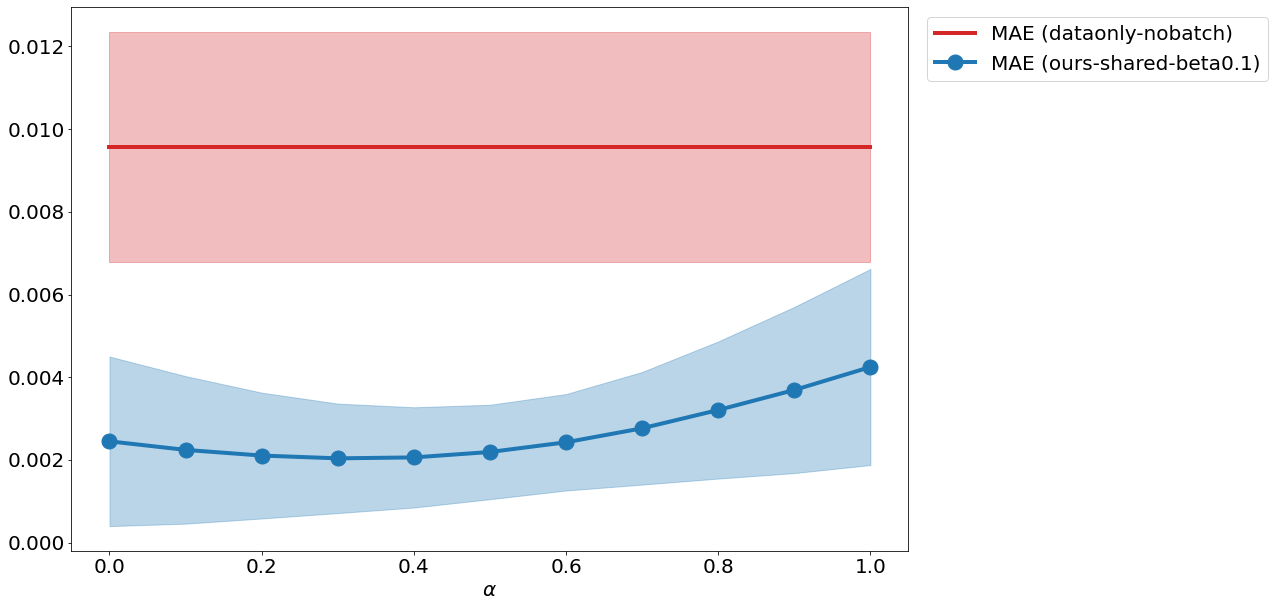

In [ ]:
'''
Visualization
'''
colors = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']*20

for key, val in ret_dict.items():
    test_loss_list = []
    test_ratio_list = []
    for seed, subval in val.items():
        if isinstance(seed, int):
            test_loss_list.append(subval['test_loss'])
            test_ratio_list.append(subval['test_ratio'])
            
    val['test_loss_avg'] = np.mean(np.array(test_loss_list), 0)
    val['test_loss_std'] = np.std(np.array(test_loss_list), 0)
    val['test_ratio_avg'] = np.mean(np.array(test_ratio_list), 0)
    val['test_ratio_std'] = np.std(np.array(test_ratio_list), 0)

key_list = ret_dict.keys()
# key_list = ['ours-shared-beta0.1']
    
i, ii = 0, 15
plt.figure(0, figsize=(15,10))
# for j, (key, val) in enumerate(ret_dict.items()):
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas[:ii], val['test_loss_avg'][:ii], ltype, color=colors[i], lw=4, ms=15, label='MAE ({})'.format(key))
    plt.fill_between(alphas[:ii], val['test_loss_avg'][:ii] - val['test_loss_std'][:ii], val['test_loss_avg'][:ii] + val['test_loss_std'][:ii], color=colors[i], alpha=0.3)
    i += 1
    
plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
# plt.xticks([])
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.ylim(0.0005, 0.003)


plt.figure(1, figsize=(15,10))
i = 0
# for j, (key, val) in enumerate(ret_dict.items()):
for key in key_list:
    val = ret_dict[key]
    ltype = '-' if key.startswith('dataonly') else 'o-'
    plt.plot(alphas, val['test_ratio_avg'], ltype, color=colors[i], lw=4, ms=15, label='Verification Ratio ({})'.format(key))
    plt.fill_between(alphas, val['test_ratio_avg'] - val['test_ratio_std'], val['test_ratio_avg'] + val['test_ratio_std'], color=colors[i], alpha=0.3)
    i += 1

plt.xlabel(r'$\alpha$', fontsize=20)
plt.xticks(fontsize=20)
# plt.xticks([])
plt.yticks(fontsize=20)
plt.legend(fontsize=20, bbox_to_anchor=(1.01, 1), loc='upper left')